***Copyright 2020 The TensorFlow Authors.***

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Lattice를 사용한 윤리에 대한 형상 제약 조건

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/shape_constraints_for_ethics"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

이 튜토리얼에서는 TensorFlow Lattice(TFL) 라이브러리를 사용하여 *책임감* 있게 작동하고 *윤리적*이거나 *공정한* 특정 가정을 위반하지 않는 모델을 훈련하는 방법을 보여줍니다. 특히 특정 속성에 대한 *불공정한 불이익*을 피하기 위해 단조성 제약 조건을 사용하는 데 초점을 맞출 것입니다. 이 튜토리얼에는 Serena Wang 및 Maya Gupta이 [AISTATS 2020](https://www.aistats.org/)에 게재한 [*Deontological Ethics By Monotonicity Shape Constraints(단조성 형상 제약 조건에 의한 의무론적 윤리)*](https://arxiv.org/abs/2001.11990) 논문의 실험 데모가 포함되어 있습니다.

공개된 데이터세트에 TFL 사전 구성 estimator를 사용할 것이지만 이 튜토리얼의 모든 내용은 TFL Keras 레이어로 구성된 모델로도 수행할 수 있습니다.

계속하기 전에 필요한 모든 패키지가 런타임에 설치되어 있는지 확인하세요(아래 코드 셀에서 가져옴).

## 설정

TF Lattice 패키지 설치하기:

In [2]:
#@test {"skip": true}
!pip install -q tensorflow-lattice seaborn

필수 패키지 가져오기:

In [3]:
import tensorflow as tf

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

이 튜토리얼에서 사용되는 기본값:

In [4]:
# List of learning rate hyperparameters to try.
# For a longer list of reasonable hyperparameters, try [0.001, 0.01, 0.1].
LEARNING_RATES = [0.01]
# Default number of training epochs and batch sizes.
NUM_EPOCHS = 1000
BATCH_SIZE = 1000
# Directory containing dataset files.
DATA_DIR = 'https://raw.githubusercontent.com/serenalwang/shape_constraints_for_ethics/master'

# 사례 연구 #1: 로스쿨 입학

이 튜토리얼의 첫 번째 부분에서는 로스쿨 입학 위원회(LSAC)의 로스쿨 입학 데이터세트를 사용한 사례 연구를 살펴봅니다. 학생의 LSAT 점수와 학부 GPA의 두 가지 특성을 사용하여 학생이 기준점을 통과할지 여부를 예측하도록 분류자를 훈련할 것입니다.

분류자의 점수가 로스쿨 입학 또는 장학금 판단 요소로 사용되었다고 가정합니다. 성과 기반 사회 규범에 따르면 GPA와 LSAT 점수가 높은 학생이 분류자로부터 더 높은 점수를 받아야 합니다. 그러나 모델이 이러한 직관적인 규범을 위반하기 쉽고 때로는 더 높은 GPA 또는 LSAT 점수를 받은 학생들에게 불이익을 주는 것을 관찰하게 됩니다.

이 *불공정한 불이익* 문제를 해결하기 위해 모델이 더 높은 GPA 또는 더 높은 LSAT 점수에 불이익을 주지 않도록 단조성 제약 조건을 적용할 수 있습니다. 이 튜토리얼에서는 TFL을 사용하여 이러한 단조성 제약 조건을 적용하는 방법을 보여줍니다.

## 로스쿨 데이터 로드하기

In [5]:
# Load data file.
law_file_name = 'lsac.csv'
law_file_path = os.path.join(DATA_DIR, law_file_name)
raw_law_df = pd.read_csv(law_file_path, delimiter=',')

데이터세트 전처리하기:

In [6]:
# Define label column name.
LAW_LABEL = 'pass_bar'

In [7]:
def preprocess_law_data(input_df):
  # Drop rows with where the label or features of interest are missing.
  output_df = input_df[~input_df[LAW_LABEL].isna() & ~input_df['ugpa'].isna() &
                       (input_df['ugpa'] > 0) & ~input_df['lsat'].isna()]
  return output_df


law_df = preprocess_law_data(raw_law_df)

### 데이터를 훈련/검증/테스트 세트로 분할하기

In [8]:
def split_dataset(input_df, random_state=888):
  """Splits an input dataset into train, val, and test sets."""
  train_df, test_val_df = train_test_split(
      input_df, test_size=0.3, random_state=random_state)
  val_df, test_df = train_test_split(
      test_val_df, test_size=0.66, random_state=random_state)
  return train_df, val_df, test_df


law_train_df, law_val_df, law_test_df = split_dataset(law_df)

### 데이터 분포 시각화하기

먼저 데이터 분포를 시각화합니다. 기준점을 통과한 모든 학생들과 통과하지 못한 모든 학생들에 대한 GPA 및 LSAT 점수를 플롯할 것입니다.

In [9]:
def plot_dataset_contour(input_df, title):
  plt.rcParams['font.family'] = ['serif']
  g = sns.jointplot(
      x='ugpa',
      y='lsat',
      data=input_df,
      kind='kde',
      xlim=[1.4, 4],
      ylim=[0, 50])
  g.plot_joint(plt.scatter, c='b', s=10, linewidth=1, marker='+')
  g.ax_joint.collections[0].set_alpha(0)
  g.set_axis_labels('Undergraduate GPA', 'LSAT score', fontsize=14)
  g.fig.suptitle(title, fontsize=14)
  # Adust plot so that the title fits.
  plt.subplots_adjust(top=0.9)
  plt.show()

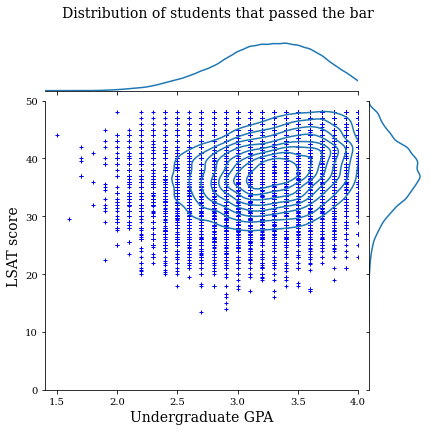

In [10]:
law_df_pos = law_df[law_df[LAW_LABEL] == 1]
plot_dataset_contour(
    law_df_pos, title='Distribution of students that passed the bar')

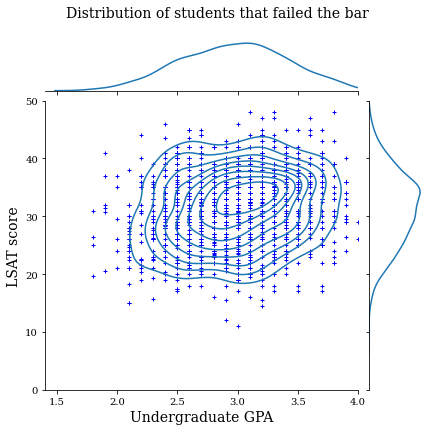

In [11]:
law_df_neg = law_df[law_df[LAW_LABEL] == 0]
plot_dataset_contour(
    law_df_neg, title='Distribution of students that failed the bar')

## 기준점 시험 통과를 예측하도록 보정된 선형 모델 훈련하기

다음으로, TFL에서 *보정된 선형 모델*을 훈련하여 학생이 기준점을 통과할지 여부를 예측합니다. 두 가지 입력 특성은 LSAT 점수와 학부 GPA이며, 훈련 레이블은 학생이 기준점을 통과했는지 여부입니다.

먼저 제약 조건 없이 보정된 선형 모델을 훈련합니다. 그런 다음, 단조성 제약 조건을 사용하여 보정된 선형 모델을 훈련하고 모델 출력 및 정확성의 차이를 관찰합니다.

### TFL 보정 선형 estimator를 훈련하기 위한 도우미 함수

이들 함수는 이 로스쿨 사례 연구와 아래의 대출 연체 사례 연구에 사용됩니다.

In [12]:
def train_tfl_estimator(train_df, monotonicity, learning_rate, num_epochs,
                        batch_size, get_input_fn,
                        get_feature_columns_and_configs):
  """Trains a TFL calibrated linear estimator.

  Args:
    train_df: pandas dataframe containing training data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rate: learning rate of Adam optimizer for gradient descent.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    estimator: a trained TFL calibrated linear estimator.

  """
  feature_columns, feature_configs = get_feature_columns_and_configs(
      monotonicity)

  model_config = tfl.configs.CalibratedLinearConfig(
      feature_configs=feature_configs, use_bias=False)

  estimator = tfl.estimators.CannedClassifier(
      feature_columns=feature_columns,
      model_config=model_config,
      feature_analysis_input_fn=get_input_fn(input_df=train_df, num_epochs=1),
      optimizer=tf.keras.optimizers.Adam(learning_rate))

  estimator.train(
      input_fn=get_input_fn(
          input_df=train_df, num_epochs=num_epochs, batch_size=batch_size))
  return estimator


def optimize_learning_rates(
    train_df,
    val_df,
    test_df,
    monotonicity,
    learning_rates,
    num_epochs,
    batch_size,
    get_input_fn,
    get_feature_columns_and_configs,
):
  """Optimizes learning rates for TFL estimators.

  Args:
    train_df: pandas dataframe containing training data.
    val_df: pandas dataframe containing validation data.
    test_df: pandas dataframe containing test data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rates: list of learning rates to try.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    A single TFL estimator that achieved the best validation accuracy.
  """
  estimators = []
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  for lr in learning_rates:
    estimator = train_tfl_estimator(
        train_df=train_df,
        monotonicity=monotonicity,
        learning_rate=lr,
        num_epochs=num_epochs,
        batch_size=batch_size,
        get_input_fn=get_input_fn,
        get_feature_columns_and_configs=get_feature_columns_and_configs)
    estimators.append(estimator)
    train_acc = estimator.evaluate(
        input_fn=get_input_fn(train_df, num_epochs=1))['accuracy']
    val_acc = estimator.evaluate(
        input_fn=get_input_fn(val_df, num_epochs=1))['accuracy']
    test_acc = estimator.evaluate(
        input_fn=get_input_fn(test_df, num_epochs=1))['accuracy']
    print('accuracies for learning rate %f: train: %f, val: %f, test: %f' %
          (lr, train_acc, val_acc, test_acc))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
  max_index = val_accuracies.index(max(val_accuracies))
  return estimators[max_index]

### 로스쿨 데이터세트 특성을 구성하기 위한 도우미 함수

이들 도우미 함수는 로스쿨 사례 연구에만 해당됩니다.

In [13]:
def get_input_fn_law(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for law school models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['ugpa', 'lsat']],
      y=input_df['pass_bar'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)


def get_feature_columns_and_configs_law(monotonicity):
  """Gets TFL feature configs for law school models."""
  feature_columns = [
      tf.feature_column.numeric_column('ugpa'),
      tf.feature_column.numeric_column('lsat'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='ugpa',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='lsat',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

### 훈련된 모델의 출력 시각화를 위한 도우미 함수

In [14]:
def get_predicted_probabilities(estimator, input_df, get_input_fn):
  predictions = estimator.predict(
      input_fn=get_input_fn(input_df=input_df, num_epochs=1))
  return [prediction['probabilities'][1] for prediction in predictions]


def plot_model_contour(estimator, input_df, num_keypoints=20):
  x = np.linspace(min(input_df['ugpa']), max(input_df['ugpa']), num_keypoints)
  y = np.linspace(min(input_df['lsat']), max(input_df['lsat']), num_keypoints)

  x_grid, y_grid = np.meshgrid(x, y)

  positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
  plot_df = pd.DataFrame(positions.T, columns=['ugpa', 'lsat'])
  plot_df[LAW_LABEL] = np.ones(len(plot_df))
  predictions = get_predicted_probabilities(
      estimator=estimator, input_df=plot_df, get_input_fn=get_input_fn_law)
  grid_predictions = np.reshape(predictions, x_grid.shape)

  plt.rcParams['font.family'] = ['serif']
  plt.contour(
      x_grid,
      y_grid,
      grid_predictions,
      colors=('k',),
      levels=np.linspace(0, 1, 11))
  plt.contourf(
      x_grid,
      y_grid,
      grid_predictions,
      cmap=plt.cm.bone,
      levels=np.linspace(0, 1, 11))  # levels=np.linspace(0,1,8));
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  cbar = plt.colorbar()
  cbar.ax.set_ylabel('Model score', fontsize=20)
  cbar.ax.tick_params(labelsize=20)

  plt.xlabel('Undergraduate GPA', fontsize=20)
  plt.ylabel('LSAT score', fontsize=20)

## 제약이 없는(단조가 아닌) 보정 선형 모델 훈련하기

In [15]:
nomon_linear_estimator = optimize_learning_rates(
    train_df=law_train_df,
    val_df=law_val_df,
    test_df=law_test_df,
    monotonicity=0,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_law,
    get_feature_columns_and_configs=get_feature_columns_and_configs_law)

accuracies for learning rate 0.010000: train: 0.949061, val: 0.945876, test: 0.951781


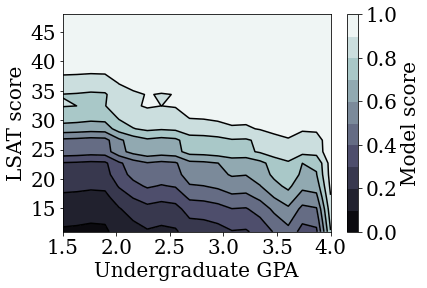

In [16]:
plot_model_contour(nomon_linear_estimator, input_df=law_df)

## 단조성 보정 선형 모델 훈련하기

In [17]:
mon_linear_estimator = optimize_learning_rates(
    train_df=law_train_df,
    val_df=law_val_df,
    test_df=law_test_df,
    monotonicity=1,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_law,
    get_feature_columns_and_configs=get_feature_columns_and_configs_law)

accuracies for learning rate 0.010000: train: 0.949249, val: 0.945447, test: 0.951781


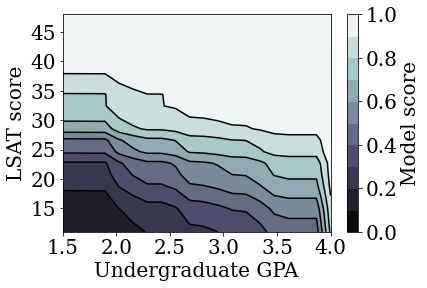

In [18]:
plot_model_contour(mon_linear_estimator, input_df=law_df)

## 다른 제약이 없는 모델 훈련하기

TFL 보정 선형 모델이 정확성을 크게 희생하지 않고도 LSAT 점수와 GPA 모두에서 단조롭도록 훈련될 수 있음을 입증했습니다.

그렇다면 보정 선형 모델이 심층 신경망(DNN) 또는 그래디언트 부스트 트리(GBT)와 같은 다른 형태의 모델과 어떻게 비교될까요? DNN과 GBT가 합리적으로 공정한 출력을 제공하는 것으로 보입니까? 이 질문의 해답을 얻기 위해 이제 제약이 없는 DNN 및 GBT를 훈련할 것입니다. 실제로, DNN과 GBT 모두 LSAT 점수와 학부 GPA에서 단조성을 쉽게 위반한다는 사실을 관찰하게 될 것입니다.

### 제약이 없는 심층 신경망(DNN) 모델 훈련하기

앞서 높은 검증 정확성을 얻기 위해 아키텍처를 최적화했습니다.

In [19]:
feature_names = ['ugpa', 'lsat']

dnn_estimator = tf.estimator.DNNClassifier(
    feature_columns=[
        tf.feature_column.numeric_column(feature) for feature in feature_names
    ],
    hidden_units=[100, 100],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
    activation_fn=tf.nn.relu)

dnn_estimator.train(
    input_fn=get_input_fn_law(
        law_train_df, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS))
dnn_train_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_train_df, num_epochs=1))['accuracy']
dnn_val_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_val_df, num_epochs=1))['accuracy']
dnn_test_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_test_df, num_epochs=1))['accuracy']
print('accuracies for DNN: train: %f, val: %f, test: %f' %
      (dnn_train_acc, dnn_val_acc, dnn_test_acc))

accuracies for DNN: train: 0.949187, val: 0.946306, test: 0.951338


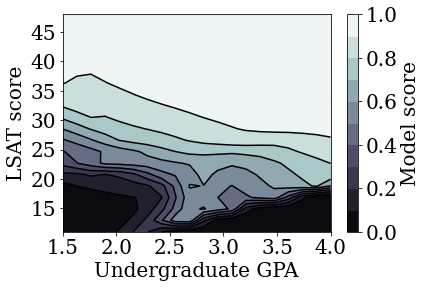

In [20]:
plot_model_contour(dnn_estimator, input_df=law_df)

### 제약이 없는 그래디언트 부스트 트리(GBT) 모델 훈련하기

앞서 높은 검증 정확성을 얻기 위해 트리 구조를 최적화했습니다.

In [21]:
tree_estimator = tf.estimator.BoostedTreesClassifier(
    feature_columns=[
        tf.feature_column.numeric_column(feature) for feature in feature_names
    ],
    n_batches_per_layer=2,
    n_trees=20,
    max_depth=4)

tree_estimator.train(
    input_fn=get_input_fn_law(
        law_train_df, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE))
tree_train_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_train_df, num_epochs=1))['accuracy']
tree_val_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_val_df, num_epochs=1))['accuracy']
tree_test_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_test_df, num_epochs=1))['accuracy']
print('accuracies for GBT: train: %f, val: %f, test: %f' %
      (tree_train_acc, tree_val_acc, tree_test_acc))

accuracies for GBT: train: 0.949249, val: 0.945017, test: 0.950896


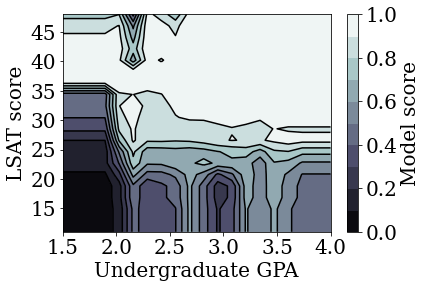

In [22]:
plot_model_contour(tree_estimator, input_df=law_df)

# 사례 연구 #2: 대출 연체

이 튜토리얼에서 고려할 두 번째 사례 연구는 개인의 대출 연체 확률을 예측하는 것입니다. UCI 리포지토리의 Default of Credit Card Clients 데이터세트를 사용합니다. 이 데이터는 30,000명의 대만 신용카드 사용자로부터 수집되었으며 사용자가 일정 기간 내에 결제를 불이행했는지 여부를 나타내는 바이너리 레이블을 포함하고 있습니다. 특성에는 결혼 여부, 성별, 학력, 사용자가 2005년 4월부터 9월까지 월별로 기존 청구액을 연체한 기간이 포함됩니다.

첫 번째 사례 연구에서와 마찬가지로, *불공정한 불이익*을 피하기 위해 단조성 제약 조건을 사용하는 방법을 다시 설명합니다. 모델을 사용하여 사용자의 신용 점수를 결정하는 경우, 다른 모든 조건이 동일할 때 청구액을 조기에 지불하는 것에 대해 불이익을 받는다면 많은 사람들이 불공정하다고 느낄 수 있습니다. 따라서 모델이 조기 결제에 불이익을 주지 않도록 하는 단조성 제약 조건을 적용합니다.

## 대출 연체 데이터 로드하기

In [23]:
# Load data file.
credit_file_name = 'credit_default.csv'
credit_file_path = os.path.join(DATA_DIR, credit_file_name)
credit_df = pd.read_csv(credit_file_path, delimiter=',')

In [24]:
# Define label column name.
CREDIT_LABEL = 'default'

### 데이터를 훈련/검증/테스트 세트로 분할하기

In [25]:
credit_train_df, credit_val_df, credit_test_df = split_dataset(credit_df)

### 데이터 분포 시각화하기

먼저 데이터 분포를 시각화합니다. 결혼 여부와 상환 상태가 서로 다른 사람들에 대해 관찰된 연체율의 평균 및 표준 오차를 플롯할 것입니다. 상환 상태는 대출 상환 기간(2005년 4월 현재)에 연체된 개월 수를 나타냅니다.

In [26]:
def get_agg_data(df, x_col, y_col, bins=11):
  xbins = pd.cut(df[x_col], bins=bins)
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
  return data


def plot_2d_means_credit(input_df, x_col, y_col, x_label, y_label):
  plt.rcParams['font.family'] = ['serif']
  _, ax = plt.subplots(nrows=1, ncols=1)
  plt.setp(ax.spines.values(), color='black', linewidth=1)
  ax.tick_params(
      direction='in', length=6, width=1, top=False, right=False, labelsize=18)
  df_single = get_agg_data(input_df[input_df['MARRIAGE'] == 1], x_col, y_col)
  df_married = get_agg_data(input_df[input_df['MARRIAGE'] == 2], x_col, y_col)
  ax.errorbar(
      df_single[(x_col, 'mean')],
      df_single[(y_col, 'mean')],
      xerr=df_single[(x_col, 'sem')],
      yerr=df_single[(y_col, 'sem')],
      color='orange',
      marker='s',
      capsize=3,
      capthick=1,
      label='Single',
      markersize=10,
      linestyle='')
  ax.errorbar(
      df_married[(x_col, 'mean')],
      df_married[(y_col, 'mean')],
      xerr=df_married[(x_col, 'sem')],
      yerr=df_married[(y_col, 'sem')],
      color='b',
      marker='^',
      capsize=3,
      capthick=1,
      label='Married',
      markersize=10,
      linestyle='')
  leg = ax.legend(loc='upper left', fontsize=18, frameon=True, numpoints=1)
  ax.set_xlabel(x_label, fontsize=18)
  ax.set_ylabel(y_label, fontsize=18)
  ax.set_ylim(0, 1.1)
  ax.set_xlim(-2, 8.5)
  ax.patch.set_facecolor('white')
  leg.get_frame().set_edgecolor('black')
  leg.get_frame().set_facecolor('white')
  leg.get_frame().set_linewidth(1)
  plt.show()

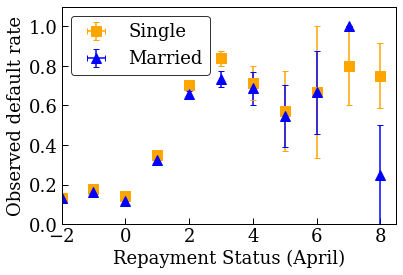

In [27]:
plot_2d_means_credit(credit_train_df, 'PAY_0', 'default',
                     'Repayment Status (April)', 'Observed default rate')

## 대출 연체율을 예측하도록 보정 선형 모델 훈련하기

다음으로, TFL에서 *보정 선형 모델*을 훈련하여 개인이 대출을 불이행할지 여부를 예측합니다. 두 가지 입력 특성은 결혼 여부와 4월에 대출금을 연체한 개월 수(상환 상태)입니다. 훈련 레이블은 대출을 연체했는지 여부입니다.

먼저 제약 조건 없이 보정된 선형 모델을 훈련합니다. 그런 다음, 단조성 제약 조건을 사용하여 보정된 선형 모델을 훈련하고 모델 출력 및 정확성의 차이를 관찰합니다.

### 대출 연체 데이터세트 특성을 구성하기 위한 도우미 함수

이들 도우미 함수는 대출 연체 사례 연구에만 해당합니다.

In [28]:
def get_input_fn_credit(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for credit default models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['MARRIAGE', 'PAY_0']],
      y=input_df['default'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)


def get_feature_columns_and_configs_credit(monotonicity):
  """Gets TFL feature configs for credit default models."""
  feature_columns = [
      tf.feature_column.numeric_column('MARRIAGE'),
      tf.feature_column.numeric_column('PAY_0'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='MARRIAGE',
          lattice_size=2,
          pwl_calibration_num_keypoints=3,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='PAY_0',
          lattice_size=2,
          pwl_calibration_num_keypoints=10,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

### 훈련된 모델의 출력 시각화를 위한 도우미 함수

In [29]:
def plot_predictions_credit(input_df,
                            estimator,
                            x_col,
                            x_label='Repayment Status (April)',
                            y_label='Predicted default probability'):
  predictions = get_predicted_probabilities(
      estimator=estimator, input_df=input_df, get_input_fn=get_input_fn_credit)
  new_df = input_df.copy()
  new_df.loc[:, 'predictions'] = predictions
  plot_2d_means_credit(new_df, x_col, 'predictions', x_label, y_label)

## 제약이 없는(단조가 아닌) 보정 선형 모델 훈련하기

In [30]:
nomon_linear_estimator = optimize_learning_rates(
    train_df=credit_train_df,
    val_df=credit_val_df,
    test_df=credit_test_df,
    monotonicity=0,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_credit,
    get_feature_columns_and_configs=get_feature_columns_and_configs_credit)

accuracies for learning rate 0.010000: train: 0.818762, val: 0.830065, test: 0.817172


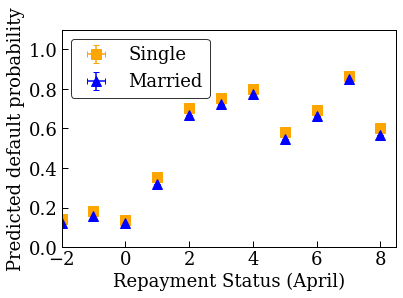

In [31]:
plot_predictions_credit(credit_train_df, nomon_linear_estimator, 'PAY_0')

## 단조 보정 선형 모델 훈련하기

In [32]:
mon_linear_estimator = optimize_learning_rates(
    train_df=credit_train_df,
    val_df=credit_val_df,
    test_df=credit_test_df,
    monotonicity=1,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_credit,
    get_feature_columns_and_configs=get_feature_columns_and_configs_credit)

accuracies for learning rate 0.010000: train: 0.818762, val: 0.830065, test: 0.817172


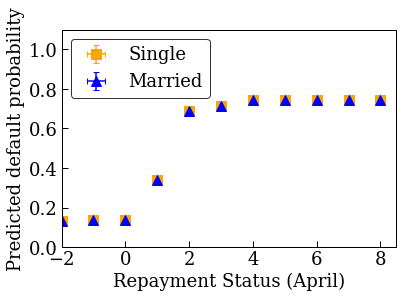

In [33]:
plot_predictions_credit(credit_train_df, mon_linear_estimator, 'PAY_0')